# Imports and reading the data

In [2]:
import networkx as nx
import pandas as pd 
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches 
import random
from collections import defaultdict
from shapely.geometry import Polygon
import operator

seed = 27

In [3]:
#reading the data
df = pd.read_csv('escorts.txt', delim_whitespace=True, index_col=False)

df_copy = df.copy()

#creating new columns in df that adds: year, month and day
df_copy['datetime'] = pd.to_datetime(df_copy['timestamp'], unit='s')

df_copy['year'] = df_copy['datetime'].dt.year
df_copy['month'] = df_copy['datetime'].dt.month
df_copy['day'] = df_copy['datetime'].dt.day

#dropping column datetime
df_copy = df_copy.drop(columns=['datetime'])

#getting rid of the timestamp
df_no_time = df.drop('timestamp', axis=1)
df_no_time.to_csv('escorts.csv', index =False, header=False)

df_no_time


,n1,n2,e
0,1,1,0
1,1,2,1
2,1,3,0
3,2,1,0
4,3,4,0
...,...,...,...
50627,8491,6621,0
50628,9136,6622,1
50629,6325,6456,1
50630,10105,6623,1


### Creating graphs

In [4]:
#creating different IDs for buyers(a) and escorts(b), so the nx function could read it
df_no_time['n1'] = 'a' + df_no_time['n1'].astype(str)

df_no_time['n2'] = 'b' + df_no_time['n2'].astype(str)

#collapsing the edges where one buyer rated the same girl more than 1 time
main_df = df_no_time.groupby(['n1', 'n2'], as_index=False).mean() #yes, it creates the means if they went to more than one escort
main_df


,n1,n2,e
0,a1,b1,0.0
1,a1,b1057,-1.0
2,a1,b12,0.0
3,a1,b130,-1.0
4,a1,b1340,-1.0
...,...,...,...
39039,a9996,b1503,1.0
39040,a9997,b125,1.0
39041,a9998,b1569,1.0
39042,a9998,b4791,1.0


In [5]:
n1_list = main_df['n1'].tolist()
n2_list = main_df['n2'].tolist()

In [6]:
#projecting the bipartite graph using vectorized projection
G = nx.from_pandas_edgelist(main_df, 'n1', 'n2', 'e')

#projecting onto the escorts
proj_G = nx.bipartite.weighted_projected_graph(G, nodes = main_df.n2.unique(), ratio=True) #ratio is number of common neighbors devided by number of buyers

#projecting onto the buyers
proj_G_b = nx.bipartite.weighted_projected_graph(G, nodes = main_df.n1.unique(), ratio=True)

## Visualisation

### Bipartite Network Graph with bipartite_layout

/Users/juliabijak/opt/anaconda3/lib/python3.9/site-packages/networkx/readwrite/pajek.py:93: UserWarning: Edge attribute e is not processed. Non-string attribute.
  warnings.warn(


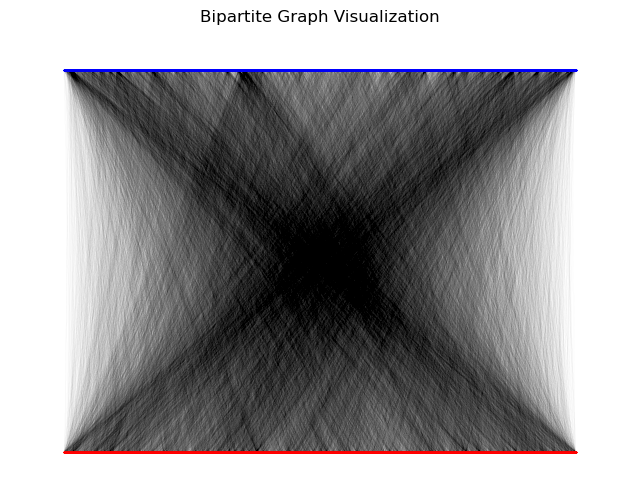

In [7]:
from networkx.drawing.layout import bipartite_layout
nx.write_pajek(G, "output_file_G.net")
network_G = nx.read_pajek("output_file_G.net")

#############################
#didnt work out for me
#G_bp = nx.DiGraph()
#G_bp.add_nodes_from()
# G.add_nodes_from("n1", bipartite=0)  # Assign 'bipartite' attribute 0 to nodes 1, 2, 3, 4
# G.add_nodes_from("n2", bipartite=1)  # Assign 'bipartite' attribute 1 to nodes 'a', 'b', 'c'

# Assigning node sets based on their bipartite attributes
# top_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
# bottom_nodes = set(G) - top_nodes
#############################

top_nodes = n1_list
bottom_nodes = n2_list

# Positioning the nodes using bipartite_layout, I used horizontal but can be vertical
pos = nx.bipartite_layout(network_G, top_nodes, align='horizontal')


plt.figure(figsize=(8, 6))

nx.draw_networkx_nodes(network_G, pos, nodelist=top_nodes, node_color='red', node_size=0.005)
nx.draw_networkx_nodes(network_G, pos, nodelist=bottom_nodes, node_color='blue', node_size=0.005)

nx.draw_networkx_edges(network_G, pos, width=0.005, edge_color='black')


plt.title('Bipartite Graph Visualization')
plt.axis('off')
plt.show()

### Bipartite Network Graph with spring_layout

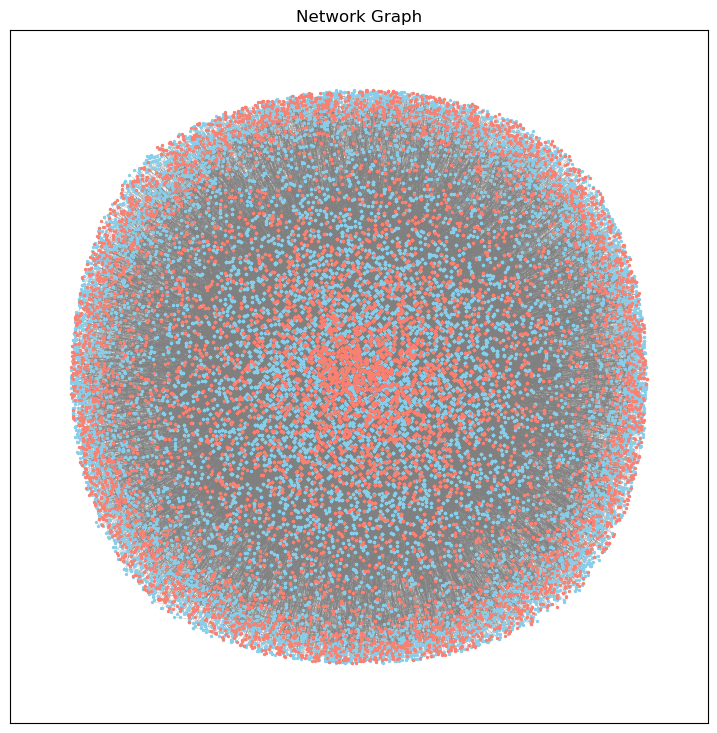

In [8]:
pos = nx.spring_layout(network_G, k=0.15)

plt.figure(figsize=(9, 9))
nx.draw_networkx_nodes(network_G, pos, nodelist=top_nodes, node_color='skyblue', node_size=2)
nx.draw_networkx_nodes(network_G, pos, nodelist=bottom_nodes, node_color='salmon', node_size=2)
nx.draw_networkx_edges(network_G, pos, width=0.15, edge_color='gray')

#nx.draw(network_G, pos, node_size=10, node_color='red', edge_color='black')

plt.title('Network Graph')
plt.show()

In [6]:
nx.write_pajek(G, "output_file_G.net")
network_G = nx.read_pajek("output_file_G.net")

/Users/juliabijak/opt/anaconda3/lib/python3.9/site-packages/networkx/readwrite/pajek.py:93: UserWarning: Edge attribute e is not processed. Non-string attribute.
  warnings.warn(


### Network Graph without nodes kinds recognision

In [9]:

pos = nx.spring_layout(network_G, k=0.15)

plt.figure(figsize=(6, 6))
nx.draw(network_G, pos, node_size=10, node_color='red', edge_color='black')
plt.title('Network Graph')
plt.show()

KeyboardInterrupt: 

# Functions

In [6]:
def give_condom(df, buyers_list):
    '''
    Function that gives condom to all the buyers in buyers_list
    and returns the DataFrame with updated edge
    '''


    mask = df['n1'].isin(buyers_list)
    df.loc[mask, 'e'] = 0.365*(1-0.8)

    return df

In [7]:

def count_unique_person2(df):
    """
    Count the unique person2 for each person1 and return a dictionary.

    Parameters:
    - df: pandas DataFrame with columns 'person1' and 'person2'

    Returns:
    - Dictionary with person1 as key and the count of unique person2 as value
    """

    # Group by 'person1' and count unique values in 'person2' for each group
    result_df = df.groupby('n1')['n2'].nunique().reset_index()

    # Convert the result to a dictionary
    result_dict = dict(zip(result_df['n1'], result_df['n2']))
    sorted_result_dict = dict(sorted(result_dict.items(), key=operator.itemgetter(1), reverse=True))


    return sorted_result_dict

top_b_links = count_unique_person2(df_no_time)

In [8]:
# Our simple SI function.
def si_simple(B, i_nodes):
   #so we can perform graph functions
   G = nx.Graph()
   G.graph.update(B.graph)
   G.add_nodes_from((n, B.nodes[n]) for n in B.nodes)
   
   new_infected = i_nodes.copy()
   for i_node in i_nodes:
        s_neighbors_of_i = {n for n in B.neighbors(i_node)}
        if len(s_neighbors_of_i) == 0:
            pass
        for s_node in s_neighbors_of_i:
            beta = B.get_edge_data(i_node, s_node, default=0)['weight'] #probability of spreading the disease
            if random.random() < beta:
                new_infected.add(s_node)
   return new_infected

In [9]:
#SIS model, doesn't work yet

# A function to make the simple IS step. Loop over
# all neighbors of nodes in I and transition them
# to S with probability mu.
def recovery(B, i_nodes, mu):
   #so we can perform graph functions
   G = nx.Graph()
   G.graph.update(B.graph)
   G.add_nodes_from((n, B.nodes[n]) for n in B.nodes)

   new_infected = i_nodes.copy()
   for i_node in i_nodes:
      if random.random() < mu:
         new_infected.remove(i_node)
   return new_infected

# Wrapper function
def sis(B, i_nodes, mu):
   #so we can perform graph functions
   G = nx.Graph()
   G.graph.update(B.graph)
   G.add_nodes_from((n, B.nodes[n]) for n in B.nodes)

   new_infected = i_nodes.copy()
   new_infected = si_simple(G, new_infected)
   new_infected = recovery(G, new_infected, mu)
   return new_infected

In [10]:
def weightz(G, u, v):
    ''' 
    Assigns weights to the edges in the projected graph based on the average weight of edges between
    u, v and their common neighbors in the original graph.

    Arguments:
        G : graph
            A NetworkX undirected bipartite graph.

        u, v : nodes
            Nodes in the graph.

    Returns:
        w: float

    Raises:
        NetworkXError
            If u or v is not a node in the graph.
    '''
    if u not in G:
        raise nx.NetworkXError("u is not in the graph.")
    if v not in G:
        raise nx.NetworkXError("v is not in the graph.")

    w = 0
    nbrs = nx.common_neighbors(G, u, v)
    for i, n in enumerate(nbrs):
        w += G.get_edge_data(u, n).get('e')
        w += G.get_edge_data(v, n).get('e')
    w = w/(2*(i+1))
    return w
    

In [11]:
def whos_faster(model1, model2):
    k1 = 0
    for k,v in model1.items():
        if v>92:
            k1=k
            break
    for k,v in model2.items():
        if v>92:
            k2=k
            break
    return k1/k2

# Basic network analysis

### On the bipartite network

In [12]:
#finding unique number of buyers and escorts
buyers = df.n1.unique().tolist()
escorts = df.n2.unique().tolist()

print(f'Unique edge count: {G.size()}')
print(f'Total number of nodes: {G.number_of_nodes()}')
print(f'Numbers of buyers: {len(buyers)}')
print(f'Numbers of escorts: {len(escorts)}')
print(f'Total number of rows: {df_no_time.shape[0]}') #num of encounters
print(f'Is the network connected? {nx.is_connected(G)}') 

avg_rating = round(float(df_no_time['e'].mean()), 3)
print(f'Average rating: {avg_rating}') #most of them satisfied ;)

Unique edge count: 39044
Total number of nodes: 16730
Numbers of buyers: 10106
Numbers of escorts: 6624
Total number of rows: 50632
Is the network connected? False
Average rating: 0.743


In [13]:
#Largest Connected Component
Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
LCC = G.subgraph(Gcc[0])
print(LCC.size())
print(f'Number of unique edges are out of the LCC: {G.size() - LCC.size()}')

38540
Number of unique edges are out of the LCC: 504


In [14]:
#finding most popular buyers(biggest amount of payments) and escorts(how many times visited)
#we need to observe that the escorts that had less buyers and had rating of 1, will have better scores than the most visited ones
#so we need to normalize it

#on df_no_time, because it contains the edges before collapsing them

#Making dataframe of popular buyers and popular escorts
pop_buyers = df_no_time['n1'].value_counts().reset_index()
pop_escorts = df_no_time['n2'].value_counts().reset_index()

#Making list of the 10 most popular buyers
b_top10 = pop_buyers['index'].head(10).tolist()
 
#Making list of the 10 most popular escorts
e_top10 = pop_escorts['index'].head(10).tolist()

In [15]:

#Dictionary of average rating of most vistied escorts (top 10 degrees)
#Key: ID of escort
#Value: Average rating
avg = {}
for escort in e_top10:
    most_pop_esc = df_no_time[df_no_time['n2'] == escort]
    ratings = most_pop_esc['e'].tolist()
    avg[escort] = round(sum(ratings)/len(ratings), 3)

print(avg)

{'b11': 0.98, 'b1565': 0.992, 'b1443': 0.96, 'b41': 0.942, 'b1345': 0.968, 'b2845': 0.977, 'b2470': 0.98, 'b1569': 0.953, 'b2799': 0.983, 'b503': 0.955}


In [16]:
#Average degrees

avg_d_b = round(float(pop_buyers['n1'].mean()), 3)
print(f'Average degree of buyers: {avg_d_b}') #how many ratings they've given

avg_d_e = round(float(pop_escorts['n2'].mean()), 3)
print(f'Average degree of escorts: {avg_d_e}') #how many times they've been rated

Average degree of buyers: 5.01
Average degree of escorts: 7.644


### On the projections

In [17]:
#number of singletons
degrees = nx.degree(proj_G)

n = 0
for key, value in degrees:
    if value == 0:
        n += 1
print(f'Numbers of singletons: {n}')

Numbers of singletons: 385


In [17]:
#basic network analysis on projected network
# proj_G.size() #num of edges
print(proj_G.number_of_edges())
print(proj_G.number_of_nodes())

#density it's a range 0-1
print(nx.density(proj_G)) #quite sparse 

183465
6624
0.008363886718878218


### Laplace's Rule of Succesion 

In [18]:
# Define Laplace's Rule of Succession function with weighted ratings
def laplace_rule_of_succession(df, rating_weights={'positive': 1, 'neutral': 0.5, 'negative': -1}):
    # Calculate the total number of reviews for each escort
    reviews_count = df.groupby('n2')['e'].count().reset_index()
    reviews_count.rename(columns={'e': 'TotalReviews'}, inplace=True)

    # Calculate the total weight for each escort
    weighted_reviews = df.groupby(['n2'])['e'].sum().reset_index()
    weighted_reviews.rename(columns={'e': 'TotalWeight'}, inplace=True)

    # Merge the weight information back into the main dataframe
    df = pd.merge(df, reviews_count, on='n2', how='left')
    df = pd.merge(df, weighted_reviews, on='n2', how='left')

    # Calculate Laplace-adjusted ratings with weighted ratings
    df['LaplaceAdjustedRating'] = (df['TotalWeight'] + rating_weights['positive']) / (df['TotalReviews'] + sum(rating_weights.values()))

    return df



In [19]:
df_test = laplace_rule_of_succession(main_df)
df_test

,n1,n2,e,TotalReviews,TotalWeight,LaplaceAdjustedRating
0,a1,b1,0.0,47,18.50,0.410526
1,a1,b1057,-1.0,83,65.25,0.793413
2,a1,b12,0.0,85,65.00,0.771930
3,a1,b130,-1.0,16,-9.00,-0.484848
4,a1,b1340,-1.0,63,46.00,0.740157
...,...,...,...,...,...,...
39039,a9996,b1503,1.0,36,28.00,0.794521
39040,a9997,b125,1.0,22,22.00,1.022222
39041,a9998,b1569,1.0,270,252.00,0.935305
39042,a9998,b4791,1.0,22,21.00,0.977778


## Degree distribution

In [19]:
#degrees in the bipartite network
bi_escorts_degrees = Counter(main_df['n2'])

bi_buyers_degrees = Counter(main_df['n1'])

#degrees in the projected
escorts_degrees = dict(proj_G.degree())
buyers_degrees = dict(proj_G_b.degree())

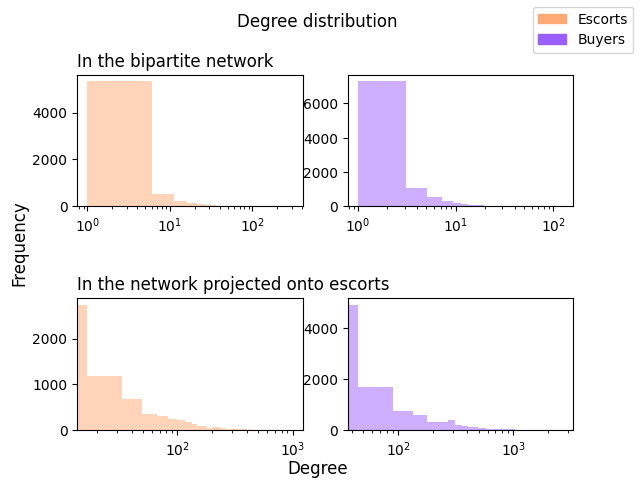

In [20]:
#Plotting degree distribution
fig, ax = plt.subplots(2, 2)

ax[0, 0].hist(bi_escorts_degrees.values(), bins=60, alpha=0.5, label='Escorts', color='#FFAA75')
ax[0,0].set_xscale('log')

ax[0, 1].hist(bi_buyers_degrees.values(), bins=60, alpha=0.5, label='Buyers', color = '#9C5FFF')
ax[0,1].set_xscale('log')

ax3 = ax[1, 0].hist(escorts_degrees.values(), bins=60, alpha=0.5, label='Escorts', color ='#FFAA75')
ax[1,0].set_xscale('log')

ax4 = ax[1, 1].hist(buyers_degrees.values(), bins=60, alpha=0.5, label='Buyers', color = '#9C5FFF')
ax[1,1].set_xscale('log')

fig.supxlabel('Degree')
fig.supylabel('Frequency')

green_patch = mpatches.Patch(color='#FFAA75', label='Escorts') 
blue_patch = mpatches.Patch(color='#9C5FFF', label='Buyers') 
fig.legend(handles=[green_patch, blue_patch], loc='upper right') 
ax[0,0].set_title('In the bipartite network', loc='left')
ax[1,0].set_title('In the network projected onto escorts', loc='left')
fig.suptitle('Degree distribution')
fig.subplots_adjust(hspace=0.7, top=0.85)

plt.show()

### Cumulative degree distribution

In [21]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True) #the degree of each nod

In [22]:
# accumulating the degrees from highest to lowest
cumulative_degrees = [degree_sequence[:i].count(degree) for i, degree in enumerate(degree_sequence)]

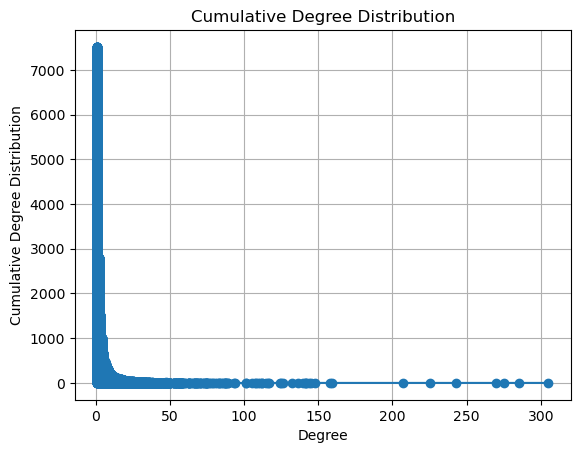

In [215]:
plt.plot(degree_sequence, cumulative_degrees, marker='o')
plt.xlabel("Degree")
plt.ylabel("Cumulative Degree Distribution")
plt.title("Cumulative Degree Distribution")
plt.grid(True)
plt.show()

# Calculating centralities to detect the hubs of the network

### Degree centrality

In [34]:
d_cent = nx.degree_centrality(proj_G)

#top 10
d_c_sorted = {k: v for k, v in sorted(d_cent.items(), key=lambda item: item[1], reverse=True)[:10]}
peri1 = {k: v for k, v in sorted(d_cent.items(), key=lambda item: item[1], reverse=False)if v >0}
peri = {k: v for k, v in sorted(peri1.items(), key=lambda item: item[1], reverse=False)[:10]}
peri

{'b6519': 0.00015098897780462027,
 'b6520': 0.00015098897780462027,
 'b6592': 0.00015098897780462027,
 'b6576': 0.00015098897780462027,
 'b6561': 0.00015098897780462027,
 'b6589': 0.00015098897780462027,
 'b6591': 0.00015098897780462027,
 'b27': 0.00015098897780462027,
 'b524': 0.00015098897780462027,
 'b1487': 0.00015098897780462027}

### Betweenness centrality

In [217]:
b_cent = nx.betweenness_centrality(proj_G, k=1000)

#top 10
b_c_sorted = {k: v for k, v in sorted(b_cent.items(), key=lambda item: item[1], reverse=True)[:10]}

### Closeness centrality

In [218]:
c_cent = nx.closeness_centrality(proj_G)

#top 10
c_c_sorted = {k: v for k, v in sorted(c_cent.items(), key=lambda item: item[1], reverse=True)[:10]}

In [219]:
#the algorithm was designed for directed graph, but it gives us some idea of hubs
hity = nx.hits(proj_G)
hity = dict(hity[0])

#top 10
hits_sorted = {k: v for k, v in sorted(hity.items(), key=lambda item: item[1], reverse=True)[:10]}

In [220]:

# Merging all 4 hub detection techniques to find unique hubs they present
hubs = list(b_c_sorted.keys()) + list(d_c_sorted.keys()) + list(c_c_sorted.keys()) + list(hits_sorted.keys())
hubs = set(hubs)
len(hubs)

16

# Community detection

In [221]:
#Community Detection
lab_prop = nx.community.label_propagation_communities(proj_G)
modularity = nx.community.greedy_modularity_communities(proj_G)

listed_lab = list(lab_prop)
listed_lab.sort(key=len, reverse=True)

In [222]:
#number of nodes in each community
for i in range(12):
    print(len(modularity[i]))

print("_________________________")

for i in range(12):
    print(len(listed_lab[i]))

1969
1360
1296
797
679
20
9
8
7
5
5
4
_________________________
2583
988
621
497
391
382
225
167
21
16
12
9


# Creating different spread models

In [23]:
## PURE RAW SEX
#CONSTANT INFECTION RATE 0.365

# 1. updating all edges in bipartite network to have 0.365
df_constant = main_df.copy()
df_constant.loc[df_constant['e'] < 2, 'e'] = 0.365

# 2. Assign random/constant probability of wearing condom on all the male buyers. Change infection rate (edgeweight) according to this.

dic_condoms = {}
male_buyers = df_constant['n1'].unique().tolist()

for buyer in male_buyers:
    p_or_n = random.randint(0,1)
    dic_condoms[buyer] = p_or_n

df_condoms = df_constant.copy()

for key, value in dic_condoms.items():
    if value == 1:
        df_condoms.loc[df_condoms['n1'] == key, 'e'] = 0.365*(1-0.8)
    

In [24]:
#projecting graph with custom weights between escorts
G_raw = nx.from_pandas_edgelist(df_constant, 'n1', 'n2', 'e')
pG_raw = nx.bipartite.generic_weighted_projected_graph(G_raw, nodes = main_df.n2.unique(), weight_function=weightz)


In [25]:
#projecting graph with custom weights between escorts
G_condoms = nx.from_pandas_edgelist(df_condoms, 'n1', 'n2', 'e')
pG_condoms = nx.bipartite.generic_weighted_projected_graph(G_condoms, nodes = main_df.n2.unique(), weight_function=weightz)


## Degree Centrality for buyers

In [26]:

d_cent_b = nx.bipartite.degree_centrality(G, nodes = df_no_time.n1.unique())
filtered_d = {key: value for key, value in d_cent_b.items() if key.startswith('a')}
d_c_b_sorted = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)}

half = int(len(filtered_d)/2)

top_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[:half]}
bottom_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[half:]}

# b_cent_b = nx.bipartite.betweenness_centrality(G, nodes = df_no_time.n1.unique())
# filtered_b = {key: value for key, value in b_cent_b.items() if key.startswith('a')}
# b_c_b_sorted = {k: v for k, v in sorted(filtered_b.items(), key=lambda item: item[1], reverse=True)[:10]}
# print(b_c_b_sorted.keys())

# c_cent_b = nx.bipartite.closeness_centrality(G, nodes = df_no_time.n1.unique())
# filtered_c = {key: value for key, value in c_cent_b.items() if key.startswith('a')}
# c_c_b_sorted = {k: v for k, v in sorted(filtered_c.items(), key=lambda item: item[1], reverse=True)[:10]}
# print(c_c_b_sorted.keys())



# # Merging all 4 hub detection techniques to find unique hubs they present
# hubs = list(b_c_b_sorted.keys()) + list(d_c_b_sorted.keys()) + list(c_c_b_sorted.keys())
# hubs = set(hubs)
# len(hubs)




In [27]:
df_tophalf_condoms = give_condom(df_constant.copy(), list(top_half))
df_bottomhalf_condoms = give_condom(df_constant.copy(), list(bottom_half))


In [28]:
#projecting graph with custom weights between escorts
G_b_top = nx.from_pandas_edgelist(df_tophalf_condoms, 'n1', 'n2', 'e')
pG_b_top = nx.bipartite.generic_weighted_projected_graph(G_b_top, nodes = df_tophalf_condoms.n2.unique(), weight_function= weightz)



In [29]:
#projecting graph with custom weights between escorts
G_b_bottom = nx.from_pandas_edgelist(df_bottomhalf_condoms, 'n1', 'n2', 'e')
pG_b_bottom = nx.bipartite.generic_weighted_projected_graph(G_b_bottom, nodes = df_bottomhalf_condoms.n2.unique(), weight_function= weightz)

## SI model

In [230]:
degrees = nx.degree(pG_condoms)

n = 0
for key, value in degrees:
    if value == 0:
        n += 1

max_infected = round(100-(n/len(pG_condoms.nodes)*100),2)
print(f'Max possible percentage of infected nodes is {max_infected}%.')

Max possible percentage of infected nodes is 94.19%.


In [28]:
basic_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_condoms = set(random.sample(list(set(pG_condoms.nodes)), 3))
   i_nodes_raw = i_nodes_condoms.copy()
   for step in range(50):
      i_nodes_condoms = si_simple(pG_condoms, i_nodes_condoms)
      i_nodes_raw = si_simple(pG_raw, i_nodes_raw)
      # Since we run 10 times, we average the infected set size
      basic_curve["condoms"][step] += (len(i_nodes_condoms) / len(pG_condoms.nodes)) * 10
      basic_curve["raw"][step] += (len(i_nodes_raw) / len(pG_raw.nodes)) * 10
      basic_curve['condoms_S'][step] = 100 - basic_curve["condoms"][step]

In [233]:
#we can see that after reaching 92% infected nodes increase very slowly, so we use that to compare

speed = round(whos_faster(basic_curve['condoms'], basic_curve['raw']),3)
print(f'Raw model was {speed} times faster than Condom model in reaching 92% infection rate.')

Raw model was 2.571 times faster than Condom model in reaching 92% infection rate.


In [234]:
hp_basic_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_hubs = set(random.sample(list(d_c_sorted.keys()), 3))
   i_nodes_peri = set(random.sample(list(peri.keys()), 3))
   for step in range(30):
      i_nodes_hubs = si_simple(pG_condoms, i_nodes_hubs)
      i_nodes_peri = si_simple(pG_condoms, i_nodes_peri)
      # Since we run 10 times, we average the infected set size
      hp_basic_curve["hubs"][step] += (len(i_nodes_hubs) / len(pG_condoms.nodes)) * 10
      hp_basic_curve["peri"][step] += (len(i_nodes_peri) / len(pG_condoms.nodes)) * 10

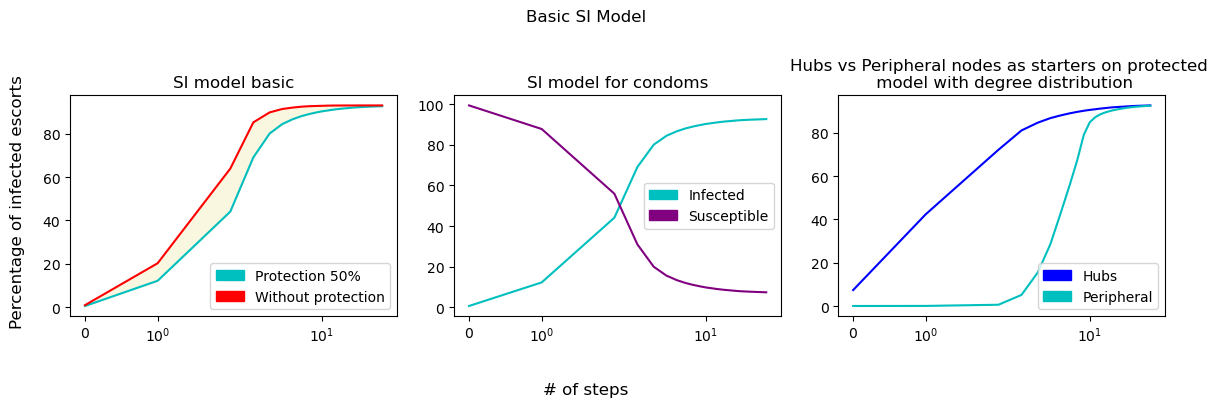

In [235]:
#Plotting simple SI model
fig, ax = plt.subplots(1, 3, figsize =(12,4))

ax[0].plot([basic_curve["condoms"][step] for step in range(30)], color = 'c', label = 'Condoms')
ax[0].plot([basic_curve["raw"][step] for step in range(30)], color = 'r', label = 'Raw')
ax[0].fill_between(range(30), [basic_curve["condoms"][step] for step in range(30)], [basic_curve["raw"][step] for step in range(30)], color ='#FAF7E1')
ax[0].set_xscale('symlog')
green_patch = mpatches.Patch(color='c', label='Protection 50%') 
blue_patch = mpatches.Patch(color='r', label='Without protection') 
ax[0].legend(handles=[blue_patch, green_patch], loc='lower right')
ax[0].set_title('SI model basic')

ax[1].plot([basic_curve["condoms"][step] for step in range(30)], color = 'c', label = 'Infected')
ax[1].plot([basic_curve['condoms_S'][step] for step in range(30)], color = 'purple', label = 'Susceptible')
ax[1].set_xscale('symlog')
green_patch = mpatches.Patch(color='c', label='Infected') 
purple_patch = mpatches.Patch(color='purple', label='Susceptible')
ax[1].legend(handles=[green_patch, purple_patch], loc='center right')
ax[1].set_title('SI model for condoms')

ax[2].plot([hp_basic_curve["hubs"][step] for step in range(30)], color = 'b', label = 'Hubs')
ax[2].plot([hp_basic_curve["peri"][step] for step in range(30)], color = 'c', label = 'Peri')
ax[2].set_xscale('symlog')
green_patch = mpatches.Patch(color='b', label='Hubs') 
blue_patch = mpatches.Patch(color='c', label='Peripheral') 
ax[2].legend(handles=[green_patch, blue_patch], loc='lower right')
ax[2].set_title('Hubs vs Peripheral nodes as starters on protected \n model with degree distribution')


fig.supxlabel('# of steps')
fig.supylabel('Percentage of infected escorts')
fig.suptitle('Basic SI Model')

fig.tight_layout(pad =1.5)

plt.show()


In [236]:
#protection given to 50% of buyers
#2 models - protection given to first half of bueyrs with highest degree centrality and vice vrsa

protect_50_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(set(pG_b_top.nodes)), 3))
   i_nodes_bottom = set(random.sample(list(set(pG_b_bottom.nodes)), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_b_top, i_nodes_top)
      i_nodes_bottom = si_simple(pG_b_bottom, i_nodes_bottom)
      # Since we run 10 times, we average the infected set size
      protect_50_curve["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protect_50_curve["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10

protection_50_hubs_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(d_c_sorted.keys()), 3))
   i_nodes_bottom = set(random.sample(list(d_c_sorted.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_b_top, i_nodes_top)
      i_nodes_bottom = si_simple(pG_b_bottom, i_nodes_bottom)
      # Since we run 10 times, we average the infected set size
      protection_50_hubs_curve["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_50_hubs_curve["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10

protection_50_peri_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(peri.keys()), 3))
   i_nodes_bottom = set(random.sample(list(peri.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_b_top, i_nodes_top)
      i_nodes_bottom = si_simple(pG_b_bottom, i_nodes_bottom)
      # Since we run 10 times, we average the infected set size
      protection_50_peri_curve["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_50_peri_curve["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10

In [30]:
third = int(len(filtered_d)/3)

top_3_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[:third]}
bottom_3_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[third:]}

seventy = int(len(filtered_d) - (len(filtered_d)/3))

top_7_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[:seventy]}
bottom_7_half = {k: v for k, v in sorted(filtered_d.items(), key=lambda item: item[1], reverse=True)[seventy:]}

In [31]:
df_tophalf_3 = give_condom(df_constant.copy(), list(top_3_half))
df_bottomhalf_3 = give_condom(df_constant.copy(), list(bottom_3_half))

df_tophalf_7 = give_condom(df_constant.copy(), list(top_7_half))
df_bottomhalf_7 = give_condom(df_constant.copy(), list(bottom_7_half))

In [32]:
G_top_3 = nx.from_pandas_edgelist(df_tophalf_3, 'n1', 'n2', 'e')
pG_top_3 = nx.bipartite.generic_weighted_projected_graph(G_top_3, nodes = df_tophalf_condoms.n2.unique(), weight_function= weightz)

G_bottom_3 = nx.from_pandas_edgelist(df_bottomhalf_3, 'n1', 'n2', 'e')
pG_bottom_3 = nx.bipartite.generic_weighted_projected_graph(G_bottom_3, nodes = df_tophalf_condoms.n2.unique(), weight_function= weightz)


G_top_7 = nx.from_pandas_edgelist(df_tophalf_7, 'n1', 'n2', 'e')
pG_top_7 = nx.bipartite.generic_weighted_projected_graph(G_top_7, nodes = df_tophalf_condoms.n2.unique(), weight_function= weightz)

G_bottom_7 = nx.from_pandas_edgelist(df_bottomhalf_7, 'n1', 'n2', 'e')
pG_bottom_7 = nx.bipartite.generic_weighted_projected_graph(G_bottom_7, nodes = df_tophalf_condoms.n2.unique(), weight_function= weightz)

In [240]:
protect_30_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(set(pG_top_3.nodes)), 3))
   i_nodes_bottom = set(random.sample(list(set(pG_bottom_3.nodes)), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_3, i_nodes_top)
      i_nodes_bottom = si_simple(pG_bottom_3, i_nodes_bottom)
      # Since we run 10 times, we average the infected set size
      protect_30_curve["top"][step] += (len(i_nodes_top) / len(pG_top_3.nodes)) * 10
      protect_30_curve["bottom"][step] += (len(i_nodes_bottom) / len(pG_bottom_3.nodes)) * 10

protection_30_hubs_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(d_c_sorted.keys()), 3))
   i_nodes_bottom = set(random.sample(list(d_c_sorted.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_3, i_nodes_top)
      i_nodes_bottom = si_simple(pG_bottom_3, i_nodes_bottom)
      # Since we run 10 times, we average the infected set size
      protection_30_hubs_curve["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_30_hubs_curve["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10

protection_30_peri_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(peri.keys()), 3))
   i_nodes_bottom = set(random.sample(list(peri.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_3, i_nodes_top)
      i_nodes_bottom = si_simple(pG_bottom_3, i_nodes_bottom)
      # Since we run 10 times, we average the infected set size
      protection_30_peri_curve["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_30_peri_curve["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10

In [241]:
protect_70_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(set(pG_top_7.nodes)), 3))
   i_nodes_bottom = set(random.sample(list(set(pG_bottom_7.nodes)), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_7, i_nodes_top)
      i_nodes_bottom = si_simple(pG_bottom_7, i_nodes_bottom)
      # Since we run 10 times, we average the infected set size
      protect_70_curve["top"][step] += (len(i_nodes_top) / len(pG_top_3.nodes)) * 10
      protect_70_curve["bottom"][step] += (len(i_nodes_bottom) / len(pG_bottom_3.nodes)) * 10

protection_70_hubs_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(d_c_sorted.keys()), 3))
   i_nodes_bottom = set(random.sample(list(d_c_sorted.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_7, i_nodes_top)
      i_nodes_bottom = si_simple(pG_bottom_7, i_nodes_bottom)
      # Since we run 10 times, we average the infected set size
      protection_70_hubs_curve["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_70_hubs_curve["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10

protection_70_peri_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(peri.keys()), 3))
   i_nodes_bottom = set(random.sample(list(peri.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_7, i_nodes_top)
      i_nodes_bottom = si_simple(pG_bottom_7, i_nodes_bottom)
      # Since we run 10 times, we average the infected set size
      protection_70_peri_curve["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_70_peri_curve["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10

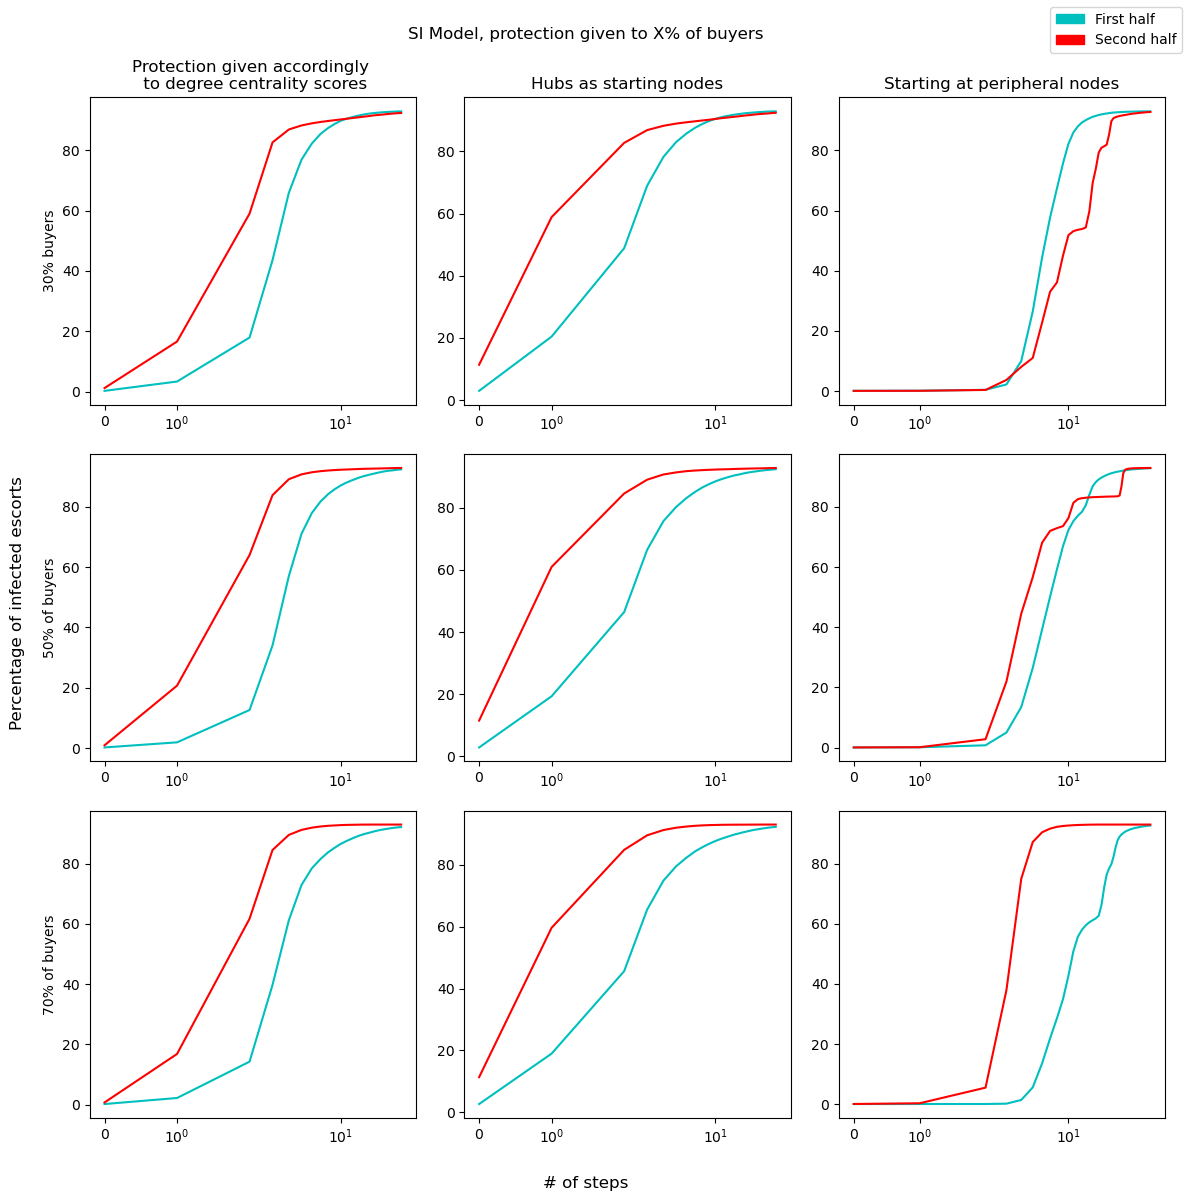

In [242]:
#Plotting simple SI model, protection given to 50% of buyers
fig, ax = plt.subplots(3, 3, figsize =(12,12))

ax[0,0].plot([protect_30_curve["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[0,0].plot([protect_30_curve["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[0,0].set_xscale('symlog')
ax[0,0].set_title('Protection given accordingly \n to degree centrality scores')
ax[0,0].set_ylabel('30% buyers')


ax[0,1].plot([protection_30_hubs_curve["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[0,1].plot([protection_30_hubs_curve["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[0,1].set_xscale('symlog')
ax[0,1].set_title('Hubs as starting nodes')


ax[0,2].plot([protection_30_peri_curve["top"][step] for step in range(50)], color = 'c', label = 'top')
ax[0,2].plot([protection_30_peri_curve["bottom"][step] for step in range(50)], color = 'r', label = 'bottom')
ax[0,2].set_xscale('symlog')
ax[0,2].set_title('Starting at peripheral nodes')

ax[1,0].plot([protect_50_curve["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[1,0].plot([protect_50_curve["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[1,0].set_xscale('symlog')
ax[1,0].set_ylabel('50% of buyers')


ax[1,1].plot([protection_50_hubs_curve["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[1,1].plot([protection_50_hubs_curve["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[1,1].set_xscale('symlog')


ax[1,2].plot([protection_50_peri_curve["top"][step] for step in range(50)], color = 'c', label = 'top')
ax[1,2].plot([protection_50_peri_curve["bottom"][step] for step in range(50)], color = 'r', label = 'bottom')
ax[1,2].set_xscale('symlog')

ax[2,0].plot([protect_70_curve["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[2,0].plot([protect_70_curve["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[2,0].set_xscale('symlog')
ax[2,0].set_ylabel('70% of buyers')


ax[2,1].plot([protection_70_hubs_curve["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[2,1].plot([protection_70_hubs_curve["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[2,1].set_xscale('symlog')


ax[2,2].plot([protection_70_peri_curve["top"][step] for step in range(50)], color = 'c', label = 'top')
ax[2,2].plot([protection_70_peri_curve["bottom"][step] for step in range(50)], color = 'r', label = 'bottom')
ax[2,2].set_xscale('symlog')




fig.supxlabel('# of steps')
fig.supylabel('Percentage of infected escorts')
fig.suptitle('SI Model, protection given to X% of buyers')

fig.tight_layout(pad =1.5)

green_patch = mpatches.Patch(color='c', label='First half') 
blue_patch = mpatches.Patch(color='r', label='Second half') 
fig.legend(handles=[green_patch, blue_patch], loc='upper right') 

plt.show()

In [243]:
## SIS
# new model

##How many have condoms
#Maybe 30, 50, 70 % have condoms. Do this afterwards
#make this condom distribution a function

##Who do we give the condoms to
#Project onto males, Calculate degree centrality to find hubs, dsitribute in the 10 biggest hubs, the 10 lowest hubs maybe.


#finding neighbors of guys and giving the condoms to them (friends paradox)
#TA q: Project onto guys or find another way of findings the males' friends


### Cliques

clique = cohesive group of people that are tightly connected to each other (and not tightly connected to people outside the group)
it's also -> maximal complete subgraph of a given graph


maximum clique = cannot be enlarged by adding one more neighboring vertex, i.e. one that does not reside only within the vertex set of a bigger clique. A clique in an undirected graph is a complete subgraph of the given graph.

In [10]:
import sys

print(sys.getrecursionlimit()) #checking what is our limit :((

3000


In [11]:
import sys
sys.setrecursionlimit(1000000) #setting it to crazy cause our network is big

In [12]:
#this is so th eerror of the limit size doesn't occur
def shut_down(s):
    if (s == "yes"):
        return "Shutting down"
    elif (s == "no"):
        return "shutdown aborted"
    else :
        return "Sorry" 

### Visualising projected network on the buyers

### Number of cliques

Number of cliques = 34

Sparse Connectivity: Having only 34 cliques in a network of 10,000 nodes suggests that the network is relatively sparse overall. This means that while there are tightly connected subsets (cliques), the connections between these subsets might be limited.

In [13]:
from collections import defaultdict
 

def find_cliques(proj_G_b):
    cliques = []
    visited = set()
 
    def dfs(node, clique):
        visited.add(node)
        clique.add(node)
 
        for neighbor in proj_G_b[node]:
            if neighbor not in visited:
                dfs(neighbor, clique)
 
    for node in proj_G_b:
        if node not in visited:
            clique = set()
            dfs(node, clique)
            if len(clique) > 1:
                cliques.append(clique)
 
    return cliques
 
 
# usage
#find_cliques() performs a depth-first search (DFS) on the graph
 
cliques = find_cliques(proj_G_b)
print(f'Number of cliques: {len(cliques)}')
print(f'Cliques: {cliques}')

Number of cliques: 34
Cliques: [{'a9432', 'a3892', 'a5465', 'a1693', 'a5840', 'a7840', 'a1915', 'a9914', 'a7791', 'a7886', 'a5774', 'a178', 'a8978', 'a1398', 'a3948', 'a8396', 'a9256', 'a657', 'a10013', 'a3519', 'a6394', 'a8511', 'a5804', 'a2052', 'a1537', 'a969', 'a9444', 'a1425', 'a1342', 'a2713', 'a1678', 'a2914', 'a6252', 'a8656', 'a2877', 'a2020', 'a4190', 'a7383', 'a678', 'a4391', 'a4136', 'a2152', 'a2427', 'a8650', 'a8964', 'a7628', 'a3242', 'a7398', 'a8642', 'a7002', 'a9969', 'a5378', 'a4483', 'a475', 'a5874', 'a1111', 'a1084', 'a7693', 'a4396', 'a5889', 'a2115', 'a1268', 'a4383', 'a2428', 'a5596', 'a4036', 'a7407', 'a7720', 'a1584', 'a9734', 'a7747', 'a3525', 'a3068', 'a1993', 'a9570', 'a9271', 'a1151', 'a9967', 'a1384', 'a9011', 'a6879', 'a3047', 'a576', 'a7878', 'a1280', 'a8272', 'a9749', 'a1714', 'a809', 'a164', 'a2658', 'a9772', 'a1618', 'a5718', 'a863', 'a7202', 'a4121', 'a5964', 'a1653', 'a129', 'a4276', 'a9674', 'a9593', 'a10061', 'a7162', 'a9317', 'a1793', 'a2782', 'a4

## Friends paradox

In [66]:
#Friends paradox for 50% people with condoms

b_degrees = nx.degree(proj_G_b)
for_sampling = [] #list consisting of buyers with friends

for k,v in b_degrees(): #making sure they have at least 1 friend
    if v>0:
        for_sampling.append(k)

In [35]:
friends_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   print(f'Run number {run}')
   condom_distributed_to = []

   while len(condom_distributed_to) != int((len(proj_G_b.nodes()))/2): #making sure it's 50% of guys
      first_random = random.sample(for_sampling, 1 )
      r_neighbors = [neighbor for neighbor in proj_G_b.neighbors(first_random[0])]
      neighbor = random.sample(r_neighbors, 1)
      if neighbor not in condom_distributed_to:
         condom_distributed_to.append(neighbor)
      else:
         pass
   df_friends = give_condom(df_constant.copy(), condom_distributed_to)
   G_friends = nx.from_pandas_edgelist(df_friends, 'n1', 'n2', 'e')
   pG_friends = nx.bipartite.generic_weighted_projected_graph(G_friends, nodes = df_friends.n2.unique(), weight_function= weightz)
   # The seed set should be the same for both models
   i_nodes_friends = set(random.sample(list(set(pG_friends.nodes)), 3))
   for step in range(50):
      i_nodes_friends = si_simple(pG_friends, i_nodes_friends)
      # Since we run 10 times, we average the infected set size
      friends_curve["friends"][step] += (len(i_nodes_friends) / len(pG_friends.nodes)) * 10

Run number 0


NameError: name 'for_sampling' is not defined

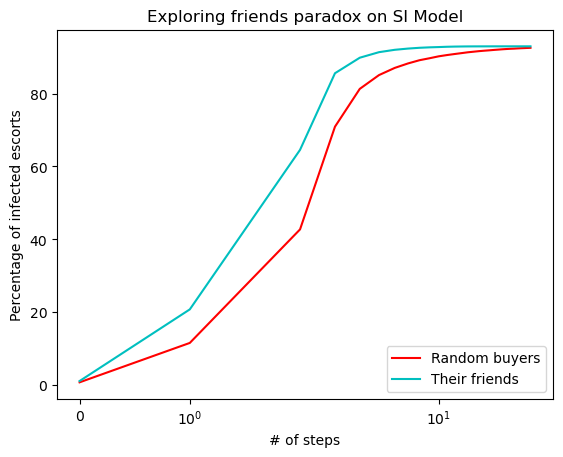

In [69]:
#Plotting simple SI model
#it looks like the raw model?? Something's wrong?

plt.plot([basic_curve["condoms"][step] for step in range(30)], color = 'r', label = 'Random buyers')
plt.plot([friends_curve["friends"][step] for step in range(30)], color = 'c', label = 'Their friends')
plt.xscale('symlog')
plt.legend(loc='lower right')

plt.xlabel('# of steps')
plt.ylabel('Percentage of infected escorts')
plt.title('Exploring friends paradox on SI Model')


plt.show()

# SIS model

In [36]:
protect_50_curve_SIS = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(set(pG_b_top.nodes)), 3))
   i_nodes_bottom = set(random.sample(list(set(pG_b_bottom.nodes)), 3))

   for step in range(50):
      i_nodes_top = si_simple(pG_b_top, i_nodes_top)
      i_nodes_top = recovery(pG_b_top, i_nodes_top, mu=0.3)
      i_nodes_bottom = si_simple(pG_b_bottom, i_nodes_bottom)
      i_nodes_bottom = recovery(pG_b_bottom, i_nodes_bottom, mu=0.3)
      # Since we run 10 times, we average the infected set size
      protect_50_curve_SIS["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protect_50_curve_SIS["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10
   print(f'50% degree centrality buyers: Run {run+1} complete.')

protection_50_hubs_curve_SIS = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(d_c_sorted.keys()), 3))
   i_nodes_bottom = set(random.sample(list(d_c_sorted.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_b_top, i_nodes_top)
      i_nodes_top = recovery(pG_b_top, i_nodes_top, mu=0.3)
      i_nodes_bottom = si_simple(pG_b_bottom, i_nodes_bottom)
      i_nodes_bottom = recovery(pG_b_bottom, i_nodes_bottom, mu=0.3)
      # Since we run 10 times, we average the infected set size
      protection_50_hubs_curve_SIS["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_50_hubs_curve_SIS["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10
   print(f'50% hub buyers: Run {run+1} complete.')

protection_50_peri_curve_SIS = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(peri.keys()), 3))
   i_nodes_bottom = set(random.sample(list(peri.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_b_top, i_nodes_top)
      i_nodes_top = recovery(pG_b_top, i_nodes_top, mu=0.3)
      i_nodes_bottom = si_simple(pG_b_bottom, i_nodes_bottom)
      i_nodes_bottom = recovery(pG_b_bottom, i_nodes_bottom, mu=0.3)
      # Since we run 10 times, we average the infected set size
      protection_50_peri_curve_SIS["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_50_peri_curve_SIS["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10
   print(f'50% peri buyers: Run {run+1} complete.')

50% degree centrality buyers: Run 1 complete.
50% degree centrality buyers: Run 2 complete.
50% degree centrality buyers: Run 3 complete.
50% degree centrality buyers: Run 4 complete.
50% degree centrality buyers: Run 5 complete.
50% degree centrality buyers: Run 6 complete.
50% degree centrality buyers: Run 7 complete.
50% degree centrality buyers: Run 8 complete.
50% degree centrality buyers: Run 9 complete.
50% degree centrality buyers: Run 10 complete.
50% hub buyers: Run 1 complete.
50% hub buyers: Run 2 complete.
50% hub buyers: Run 3 complete.
50% hub buyers: Run 4 complete.
50% hub buyers: Run 5 complete.
50% hub buyers: Run 6 complete.
50% hub buyers: Run 7 complete.
50% hub buyers: Run 8 complete.
50% hub buyers: Run 9 complete.
50% hub buyers: Run 10 complete.
50% peri buyers: Run 1 complete.
50% peri buyers: Run 2 complete.
50% peri buyers: Run 3 complete.
50% peri buyers: Run 4 complete.
50% peri buyers: Run 5 complete.
50% peri buyers: Run 6 complete.
50% peri buyers: Run

In [37]:
protect_70_curve_SIS = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(set(pG_top_7.nodes)), 3))
   i_nodes_bottom = set(random.sample(list(set(pG_bottom_7.nodes)), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_7, i_nodes_top)
      i_nodes_top = recovery(pG_top_7, i_nodes_top, mu=0.3)
      i_nodes_bottom = si_simple(pG_bottom_7, i_nodes_bottom)
      i_nodes_bottom = recovery(pG_top_7, i_nodes_top, mu=0.3)
      # Since we run 10 times, we average the infected set size
      protect_70_curve_SIS["top"][step] += (len(i_nodes_top) / len(pG_top_3.nodes)) * 10
      protect_70_curve_SIS["bottom"][step] += (len(i_nodes_bottom) / len(pG_bottom_3.nodes)) * 10
   print(f'degree buyers: Run {run+1} complete.')

protection_70_hubs_curve_SIS = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(d_c_sorted.keys()), 3))
   i_nodes_bottom = set(random.sample(list(d_c_sorted.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_7, i_nodes_top)
      i_nodes_top = recovery(pG_bottom_7, i_nodes_top, mu=0.3)
      i_nodes_bottom = si_simple(pG_bottom_7, i_nodes_bottom)
      i_nodes_bottom = recovery(pG_bottom_7, i_nodes_top, mu=0.3)
      # Since we run 10 times, we average the infected set size
      protection_70_hubs_curve_SIS["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_70_hubs_curve_SIS["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10
   print(f'hub buyers: Run {run+1} complete.')

protection_70_peri_curve_SIS = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(peri.keys()), 3))
   i_nodes_bottom = set(random.sample(list(peri.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_7, i_nodes_top)
      i_nodes_top = recovery(pG_bottom_7, i_nodes_top, mu=0.3)
      i_nodes_bottom = si_simple(pG_bottom_7, i_nodes_bottom)
      i_nodes_bottom = recovery(pG_bottom_7, i_nodes_top, mu=0.3)
      # Since we run 10 times, we average the infected set size
      protection_70_peri_curve_SIS["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_70_peri_curve_SIS["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10
   print(f'peri buyers: Run {run+1} complete.')

degree buyers: Run 1 complete.
degree buyers: Run 2 complete.
degree buyers: Run 3 complete.
degree buyers: Run 4 complete.
degree buyers: Run 5 complete.
degree buyers: Run 6 complete.
degree buyers: Run 7 complete.
degree buyers: Run 8 complete.
degree buyers: Run 9 complete.
degree buyers: Run 10 complete.
hub buyers: Run 1 complete.
hub buyers: Run 2 complete.
hub buyers: Run 3 complete.
hub buyers: Run 4 complete.
hub buyers: Run 5 complete.
hub buyers: Run 6 complete.
hub buyers: Run 7 complete.
hub buyers: Run 8 complete.
hub buyers: Run 9 complete.
hub buyers: Run 10 complete.
peri buyers: Run 1 complete.
peri buyers: Run 2 complete.
peri buyers: Run 3 complete.
peri buyers: Run 4 complete.
peri buyers: Run 5 complete.
peri buyers: Run 6 complete.
peri buyers: Run 7 complete.
peri buyers: Run 8 complete.
peri buyers: Run 9 complete.
peri buyers: Run 10 complete.


In [38]:
protect_30_curve_SIS = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(set(pG_top_3.nodes)), 3))
   i_nodes_bottom = set(random.sample(list(set(pG_bottom_3.nodes)), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_3, i_nodes_top)
      i_nodes_top = recovery(pG_top_3, i_nodes_top, mu=0.3)
      i_nodes_bottom = si_simple(pG_bottom_3, i_nodes_bottom)
      i_nodes_bottom = recovery(pG_bottom_3, i_nodes_bottom, mu=0.3)
      # Since we run 10 times, we average the infected set size
      protect_30_curve_SIS["top"][step] += (len(i_nodes_top) / len(pG_top_3.nodes)) * 10
      protect_30_curve_SIS["bottom"][step] += (len(i_nodes_bottom) / len(pG_bottom_3.nodes)) * 10
   print(f'degree buyers: Run {run+1} complete.')
    

protection_30_hubs_curve_SIS = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(d_c_sorted.keys()), 3))
   i_nodes_bottom = set(random.sample(list(d_c_sorted.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_3, i_nodes_top)
      i_nodes_top = recovery(pG_top_3, i_nodes_top, mu=0.3)
      i_nodes_bottom = si_simple(pG_bottom_3, i_nodes_bottom)
      i_nodes_bottom = recovery(pG_top_3, i_nodes_top, mu=0.3)
      # Since we run 10 times, we average the infected set size
      protection_30_hubs_curve_SIS["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_30_hubs_curve_SIS["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10
   print(f'hub buyers: Run {run+1} complete.')

protection_30_peri_curve_SIS = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_top = set(random.sample(list(peri.keys()), 3))
   i_nodes_bottom = set(random.sample(list(peri.keys()), 3))
   for step in range(50):
      i_nodes_top = si_simple(pG_top_3, i_nodes_top)
      i_nodes_top = recovery(pG_top_3, i_nodes_top, mu=0.3)
      i_nodes_bottom = si_simple(pG_bottom_3, i_nodes_bottom)
      i_nodes_bottom = recovery(pG_top_3, i_nodes_top, mu=0.3)
      # Since we run 10 times, we average the infected set size
      protection_30_peri_curve_SIS["top"][step] += (len(i_nodes_top) / len(pG_b_top.nodes)) * 10
      protection_30_peri_curve_SIS["bottom"][step] += (len(i_nodes_bottom) / len(pG_b_bottom.nodes)) * 10
   print(f'degree buyers: Run {run+1} complete.')

degree buyers: Run 1 complete.
degree buyers: Run 2 complete.
degree buyers: Run 3 complete.
degree buyers: Run 4 complete.
degree buyers: Run 5 complete.
degree buyers: Run 6 complete.
degree buyers: Run 7 complete.
degree buyers: Run 8 complete.
degree buyers: Run 9 complete.
degree buyers: Run 10 complete.
hub buyers: Run 1 complete.
hub buyers: Run 2 complete.
hub buyers: Run 3 complete.
hub buyers: Run 4 complete.
hub buyers: Run 5 complete.
hub buyers: Run 6 complete.
hub buyers: Run 7 complete.
hub buyers: Run 8 complete.
hub buyers: Run 9 complete.
hub buyers: Run 10 complete.
degree buyers: Run 1 complete.
degree buyers: Run 2 complete.
degree buyers: Run 3 complete.
degree buyers: Run 4 complete.
degree buyers: Run 5 complete.
degree buyers: Run 6 complete.
degree buyers: Run 7 complete.
degree buyers: Run 8 complete.
degree buyers: Run 9 complete.
degree buyers: Run 10 complete.


In [244]:
model_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_condoms = set(random.sample(list(set(pG_condoms.nodes)), 3))
   i_nodes_raw = i_nodes_condoms.copy()
   for step in range(50):
      i_nodes_condoms = si_simple(pG_condoms, i_nodes_condoms)
      i_nodes_condoms = recovery(pG_condoms, i_nodes_condoms, mu=0.3)
      i_nodes_raw = si_simple(pG_raw, i_nodes_raw)
      i_nodes_raw = recovery(pG_raw, i_nodes_raw, mu=0.3)
      # Since we run 10 times, we average the infected set size
      model_curve["condoms"][step] += (len(i_nodes_condoms) / len(pG_condoms.nodes)) * 10
      model_curve["raw"][step] += (len(i_nodes_raw) / len(pG_raw.nodes)) * 10
      model_curve['condoms_S'][step] = 100 - model_curve["condoms"][step]

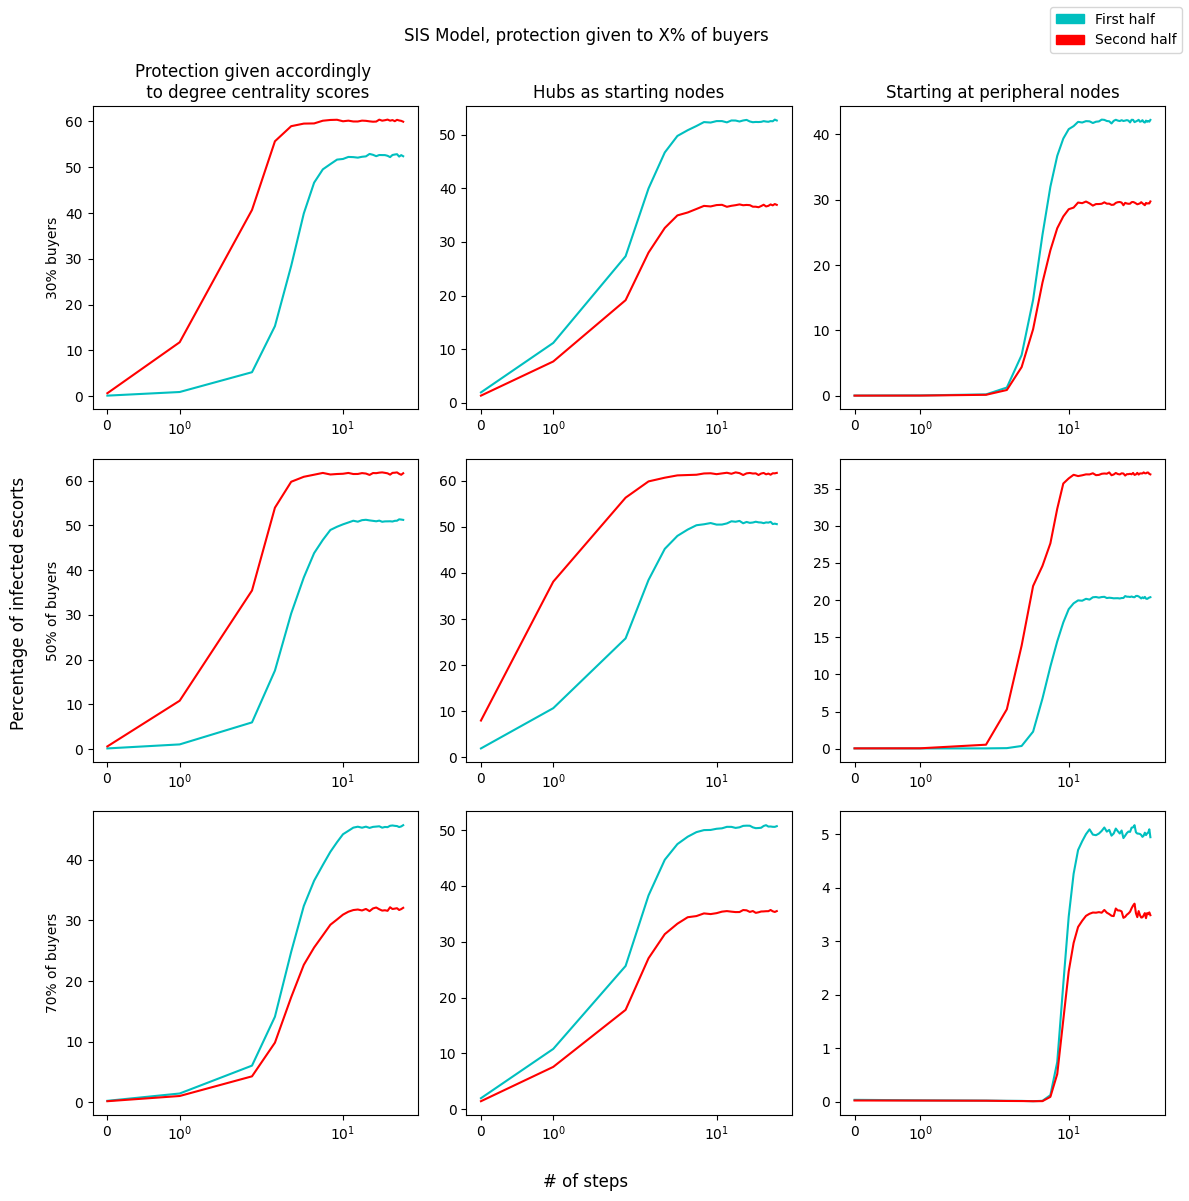

In [39]:
#Plotting simple SI model, protection given to 50% of buyers
fig, ax = plt.subplots(3, 3, figsize =(12,12))

ax[0,0].plot([protect_30_curve_SIS["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[0,0].plot([protect_30_curve_SIS["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[0,0].set_xscale('symlog')
ax[0,0].set_title('Protection given accordingly \n to degree centrality scores')
ax[0,0].set_ylabel('30% buyers')


ax[0,1].plot([protection_30_hubs_curve_SIS["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[0,1].plot([protection_30_hubs_curve_SIS["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[0,1].set_xscale('symlog')
ax[0,1].set_title('Hubs as starting nodes')


ax[0,2].plot([protection_30_peri_curve_SIS["top"][step] for step in range(50)], color = 'c', label = 'top')
ax[0,2].plot([protection_30_peri_curve_SIS["bottom"][step] for step in range(50)], color = 'r', label = 'bottom')
ax[0,2].set_xscale('symlog')
ax[0,2].set_title('Starting at peripheral nodes')

ax[1,0].plot([protect_50_curve_SIS["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[1,0].plot([protect_50_curve_SIS["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[1,0].set_xscale('symlog')
ax[1,0].set_ylabel('50% of buyers')


ax[1,1].plot([protection_50_hubs_curve_SIS["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[1,1].plot([protection_50_hubs_curve_SIS["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[1,1].set_xscale('symlog')


ax[1,2].plot([protection_50_peri_curve_SIS["top"][step] for step in range(50)], color = 'c', label = 'top')
ax[1,2].plot([protection_50_peri_curve_SIS["bottom"][step] for step in range(50)], color = 'r', label = 'bottom')
ax[1,2].set_xscale('symlog')

ax[2,0].plot([protect_70_curve_SIS["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[2,0].plot([protect_70_curve_SIS["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[2,0].set_xscale('symlog')
ax[2,0].set_ylabel('70% of buyers')


ax[2,1].plot([protection_70_hubs_curve_SIS["top"][step] for step in range(30)], color = 'c', label = 'top')
ax[2,1].plot([protection_70_hubs_curve_SIS["bottom"][step] for step in range(30)], color = 'r', label = 'bottom')
ax[2,1].set_xscale('symlog')


ax[2,2].plot([protection_70_peri_curve_SIS["top"][step] for step in range(50)], color = 'c', label = 'top')
ax[2,2].plot([protection_70_peri_curve_SIS["bottom"][step] for step in range(50)], color = 'r', label = 'bottom')
ax[2,2].set_xscale('symlog')

fig.supxlabel('# of steps')
fig.supylabel('Percentage of infected escorts')
fig.suptitle('SIS Model, protection given to X% of buyers')

fig.tight_layout(pad =1.5)

green_patch = mpatches.Patch(color='c', label='First half') 
blue_patch = mpatches.Patch(color='r', label='Second half') 
fig.legend(handles=[green_patch, blue_patch], loc='upper right') 

plt.show()

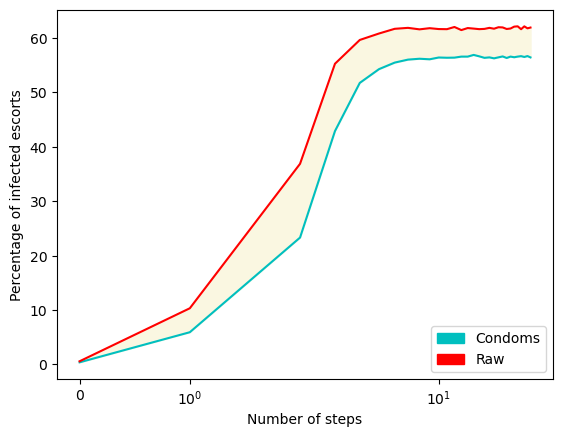

In [245]:
plt.plot([model_curve["condoms"][step] for step in range(30)], color = 'c', label = 'Condoms')
plt.plot([model_curve["raw"][step] for step in range(30)], color = 'r', label = 'Raw')
plt.ylabel('Percentage of infected escorts')
plt.xlabel('Number of steps')
plt.fill_between(range(30), [model_curve["condoms"][step] for step in range(30)], [model_curve["raw"][step] for step in range(30)], color ='#FAF7E1')
plt.xscale('symlog')
green_patch = mpatches.Patch(color='c', label='Condoms') 
blue_patch = mpatches.Patch(color='r', label='Raw') 
plt.legend(handles=[green_patch, blue_patch], loc='lower right')
plt.show()

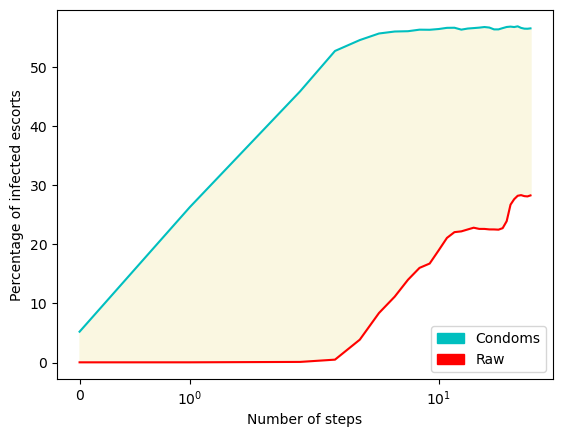

In [246]:
model_curve = defaultdict(lambda : defaultdict(float))
for run in range(10):
   # The seed set should be the same for both models
   i_nodes_hubs = set(random.sample(list(d_c_sorted.keys()), 3))
   i_nodes_peri = set(random.sample(list(peri.keys()), 3))
   for step in range(50):
      i_nodes_hubs = si_simple(pG_condoms, i_nodes_hubs)
      i_nodes_hubs = recovery(pG_condoms, i_nodes_hubs, mu=0.3)
      i_nodes_peri = si_simple(pG_condoms, i_nodes_peri)
      i_nodes_peri = recovery(pG_condoms, i_nodes_peri, mu=0.3)
      # Since we run 10 times, we average the infected set size
      model_curve["condoms"][step] += (len(i_nodes_hubs) / len(pG_condoms.nodes)) * 10
      model_curve["raw"][step] += (len(i_nodes_peri) / len(pG_condoms.nodes)) * 10
      model_curve['condoms_S'][step] = 100 - model_curve["condoms"][step]

plt.plot([model_curve["condoms"][step] for step in range(30)], color = 'c', label = 'Condoms')
plt.plot([model_curve["raw"][step] for step in range(30)], color = 'r', label = 'Raw')
plt.ylabel('Percentage of infected escorts')
plt.xlabel('Number of steps')
plt.fill_between(range(30), [model_curve["condoms"][step] for step in range(30)], [model_curve["raw"][step] for step in range(30)], color ='#FAF7E1')
plt.xscale('symlog')
green_patch = mpatches.Patch(color='c', label='Condoms') 
blue_patch = mpatches.Patch(color='r', label='Raw') 
plt.legend(handles=[green_patch, blue_patch], loc='lower right')
plt.show()